In [82]:
import numpy as np
import matplotlib.pyplot as plt
import gymnasium as gym

## Module 1: Environment setup

In [83]:
env = gym.make("FrozenLake-v1", is_slippery=False)

def render(env , state):
    grid_size = int(np.sqrt(env.observation_space.n))
    grid = np.array(list(env.unwrapped.desc.flatten()) , dtype = 'str').reshape(grid_size, grid_size)
    
    row, col = np.unravel_index(state, (grid_size, grid_size))
    
    for r in grid:
        print(" ".join(r))
    print()

state , info = env.reset()
render(env, state)

'''
    --------------------------------------------------
    UNCOMMENT THE CODE BELOW TO MANUALLY PLAY THE GAME
    --------------------------------------------------
'''

'''
done = False
while not done:
    action = int(input("Enter action (0=Left, 1=Down, 2=Right, 3=Up): "))
    state, reward, done, truncated, info = env.step(action)
    render(env, state)
    if done:
        print("Game Over! Reward:", reward)

'''

pass

S F F F
F H F H
F F F H
H F F G



In [84]:
class TQL:
    '''
        ------------------------
        Module 2: initialization
        ------------------------
    '''
    
    def __init__(self, env ,n_iter = 100, max_step = 100, alpha = 0.01, gamma = 1.0, epsilon = 1.0, epsilon_min = 0.05, epsilon_decay = 0.999):
        self.env = env
        self.n_iter = n_iter
        self.max_step = max_step
        self.alpha = alpha                    # learning rate
        self.gamma = gamma                    # discount factor
        self.epsilon = epsilon                # exploration start
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay

        self.n_states = self.env.observation_space.n
        self.n_actions = self.env.action_space.n

        self.Q = np.zeros((self.n_states, self.n_actions), dtype=np.float32)

    '''
        ---------------------------------
        Module 3: Policy (epsilon-greedy)
        ---------------------------------
    '''
    def choose_action(self , state):
        if np.random.rand() < self.epsilon:
            # exploration
            return self.env.action_space.sample()
        else: 
            # exploitation
            return np.argmax(self.Q[state])

    def decay_epsilon(self):
        if self.epsilon > self.epsilon_min:
            self.epsilon = self.epsilon * self.epsilon_decay

    '''
        ------------------
        Module 4: Q-update
        ------------------
    '''
    def update(self , state , action, reward, next_state, done):
        
        best_action = np.argmax(self.Q[next_state]) if not done else 0

        # compute temporal difference (TD) target
        td_target = reward + (self.gamma * self.Q[next_state, best_action] * (not done))

        # compute TD error
        td_error = td_target - self.Q[state, action]

        # update rule
        self.Q[state, action] += self.alpha * td_error
        
    '''
        -----------------------
        Module 5: training loop
        -----------------------
    '''
    def train(self):
        rewards_per_episode = []

        # loop over episodes
        for episode in range(self.n_iter):
            state , info = self.env.reset()
            total_reward = 0

            # loop over steps within episode
            for step in range(self.max_step):
                action = self.choose_action(state)

                # take next step in the env
                next_state, reward, done, _ , _ = self.env.step(action)

                # update Q-values
                self.update(state , action, reward, next_state, done)

                # accumulate rewards
                total_reward += reward

                # move to next state
                state = next_state

                # stop if terminal
                if done:
                    break

            # decay exploration rate
            self.decay_epsilon()   

            # store results
            rewards_per_episode.append(total_reward)
                

        return rewards_per_episode
            
            

## Model execution

In [85]:
model = TQL(env , n_iter = 50000 , alpha = 0.01)  
rewards = model.train()
print("Training success rate:", sum(rewards)/len(rewards))

Training success rate: 0.93138


## Best Moves learned by the model 

In [86]:
action_map = {0:'←', 1:'↓', 2:'→', 3:'↑'}
g = int(np.sqrt(env.observation_space.n))
grid = np.array(list(env.unwrapped.desc.flatten()) , dtype = 'str').reshape(g, g)


for i , v in enumerate(model.Q):
    move = np.argmax(v)
    coord = np.unravel_index(i, (g,g))
    if grid[coord] == 'H' or grid[coord] == 'G':
        continue
    else:    
        grid[coord] = action_map[move]

for r in grid:
    print(" ".join(r))
    

↓ ← ↓ ←
↓ H ↓ H
→ ↓ ↓ H
H → → G


## Success rate over time

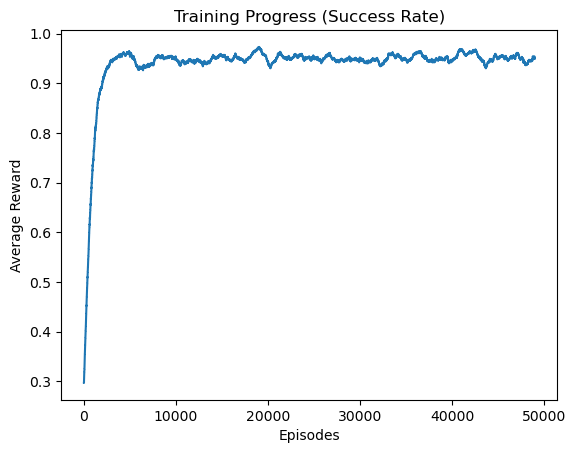

In [87]:
window = 1000
moving_avg = np.convolve(rewards, np.ones(window)/window, mode="valid")
plt.plot(moving_avg)
plt.title("Training Progress (Success Rate)")
plt.xlabel("Episodes")
plt.ylabel("Average Reward")
plt.show()